# COMP90051 Workshop 5
## The Perceptron
***
In this worksheet, we'll implement the perceptron (a building block of neural networks) from scratch. 
Our key objectives are:

* to review the steps involved in the perceptron training algorithm, 
* to assess how the perceptron behaves in two distinct scenarios (separable vs. non-separable data).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from sklearn.datasets import make_classification

### 1. Synthetic data set
We'll use the built-in `make_classification` function from `sklearn` to generate a synthetic binary classification data set.
The main advantage of using synthetic data is that we have complete control over the distribution. 
This is useful for studying machine learning algorithms under specific conditions.
In particular, we'll be varying the *degree of separability* between the two classes by adjusting the `class_sep` parameter below.
To begin, we'll work with a data set that is almost linearly separable (with `class_sep = 2`).

**Note:** In this worksheet we deviate from the standard `0`/`1` encoding for binary class labels used in `sklearn`. 
We use `-1` in place of `0` for the "negative" class to make the mathematical presentation of the perceptron algorithm easier to digest.

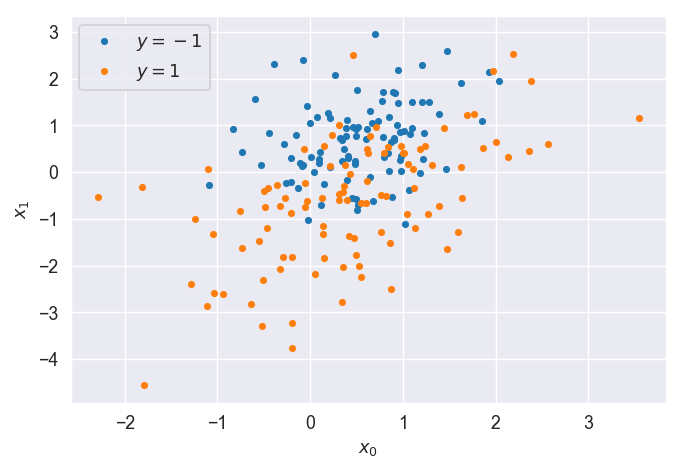

In [15]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

def create_toy_data(n_samples=200, class_sep=2):
    X, Y = make_classification(n_samples=200, n_features=2, n_informative=2, 
                               n_redundant=0, n_clusters_per_class=1, flip_y=0,
                               class_sep=class_sep, random_state=1)
    Y[Y==0] = -1 # encode "negative" class using -1 rather than 0
    plt.plot(X[Y==-1,0], X[Y==-1,1], ".", label="$y = -1$")
    plt.plot(X[Y==1,0], X[Y==1,1], ".", label="$y = 1$")
    plt.legend()
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()

    return X,Y

X, Y = create_toy_data(class_sep=.5)

**Question:** Is the perceptron a suitable classifier for this data set?
  
In preparation for training and evaluating a perceptron on this data, we randomly partition the data into train/test sets.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))

Training set has 134 instances. Test set has 66 instances.


### 2. Definition of the perceptron

Recall from lectures that a perceptron is a linear binary classifier which maps an input vector $\mathbf{x} \in \mathbb{R}^D$ to a binary output $y \in \{-1,1\}$ given by
$$
\begin{align*}
f(\mathbf{x}; \mathbf{w}, b) &= \begin{cases}
    1 & \mathrm{if} \ s(\mathbf{x}; \mathbf{w}, b) \geq 0, \\
    -1 & \mathrm{otherwise},
\end{cases}
\end{align*}
$$
where $s(\mathbf{x}; \mathbf{w}, b) = \mathbf{w} \cdot \mathbf{x} + b$. 
Here $\mathbf{w} \in \mathbb{R}^D$ is a vector of weights (one for each feature) and $b$ is the bias term.

Let start by implementing the weighted sum function $s(\mathbf{x}; \mathbf{w}, b)$ below. This is the 'inner product' $\langle\mathbf{w}, \mathbf{x}\rangle = \sum_i w_i x_i$, which captures the geometrical alignment of the weight and instance vectors. 

In [17]:
def weighted_sum(X, w, b):
    """
    Returns an array containing the weighted sum s(x) for each instance x in the feature matrix
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector
    b : float
        bias term
    """
    return np.dot(X,w) + b

def predict(X, w, b):
    """
    Returns an array containing the predicted binary labels (-1/1) for each instance in the feature matrix
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector
    b : float
        bias term
    """
    return np.where(weighted_sum(X,w,b) >=0,1,-1)

### 3. Perceptron training algorithm

We will now implement the Perceptron training algorithm first proposed by Rosenblatt in 1957. 

This is an online algorithm in the sense that it examples one point $\mathbf{x}_t$ at a time. At each stage, the algorithm maintains a weight vector $\mathbf{w}_t$ which defines the learned (hyper)plane separating the two classes. For convenience one typically starts with $\mathbf{w}_0 = 0$. The label of the point $\mathbf{x}_t$ is predicted using the sign of the dot product: $\hat{y}_t = \mathrm{sign}(\mathbf{w}_t \cdot \mathbf{x}_t)$. If $\mathbf{x}_t$ is misclassified, $y_t \mathbf{x} \cdot \mathbf{w}_t$ is negative and we make a correction to the weight vector $\mathbf{w}_{t+1} = \mathbf{w}_t + \eta y_t \mathbf{x}_t$ for some learning rate $\eta >0$. To motivate this, consider the dot product of the weight vector after the update with the misclassified instance: 

\begin{align}
y_t (\mathbf{w}_t + \eta y_t \mathbf{x}_t) \cdot \mathbf{x}_t &= y_t \mathbf{w}_t \cdot \mathbf{x}_t + \eta ||\mathbf{x}_t ||^2\\
&\geq y_t \mathbf{w}_t \cdot \mathbf{x}_t
\end{align}

So we reduce the severity of the error by an additive correction $\eta || \mathbf{x}_t ||^2$. We repeat this procedure until convergence or termination after a set limit of iterations. Pseudocode of the algorithm is shown below (taken from _Foundations of Machine Learning, Mohri, 2019_).

<img src="https://i.imgur.com/N6NZrAC.png" alt="Perceptron alg." width="750"/>

**Note:** After iterating through all of the training instances $t=[1, \ldots, T]$, we have completed one *epoch*. The above pseudocode runs for one epoch. Typically, multiple epochs are required to get close to the optimal solution.

The above training procedure is equivalent to performing sequential gradient descent on the following objective function:

\begin{align}
    F(\mathbf{w}) &= \frac{1}{T} \sum_{t=1}^T \max\left(0, -y_t (\mathbf{w} \cdot \mathbf{x}_t)\right) \\
    \mathbf{w}_{t+1} &\leftarrow \mathbf{w}_t - \eta \nabla_{\mathbf{w}} F(\mathbf{w}) 
\end{align}

To motivate the form of $F(\mathbf{w})$, note that if $\mathbf{x}_t$ is misclassified, $-y_t \mathbf{w}_t \cdot \mathbf{x}_t > 0$. In this case the gradient is $\nabla_{\mathbf{w}} F(\mathbf{w}) = -y_t \mathbf{x}_t$, and zero if the instance is correctly classified. Omitting technical details about the case where $\mathbf{w}_t \cdot \mathbf{x}_t = 0$ (we can resolve the non-differentiability by working with _subgradients_), the stochastic online update becomes:

$$ \mathbf{w}_{t+1} \leftarrow
  \begin{cases}
    \mathbf{w}_t + \eta y_t \mathbf{x}_t, & \text{if } y_t\left(\mathbf{x}_t \cdot \mathbf{w}_t\right) \leq 0; \\
    \mathbf{w}_t, & \text{if } y_t\left(\mathbf{x}_t \cdot \mathbf{w}_t\right) > 0 \\
  \end{cases}
$$

Let's now write a function called `train` which implements sequential gradient descent. The function should implement the pseudocode shown above, repeated for `n_epochs`. 

In [18]:
def train(X, Y, w, b, n_epochs=10, eta=0.1):
    """
    Returns updated weight vector w and bias term b for
    the Perceptron algorithm
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    Y : numpy array, shape: (n_instances,)
        target class labels relative to X
    n_epochs : int
        number of epochs (full sweeps through X)
    w : numpy array, shape: (n_features,)
        initial guess for weights vector w_0
    b : float
        initial guess for bias term b_0
    eta : positive float
        step size (default: 0.1)
    """
    errors = 0
    for t in range(n_epochs):
        # loop over individual elements in X
        for i in range(X.shape[0]):
            yhat = predict(X[i,:],w,b) # fill in
            if yhat != Y[i]:
                errors += 1
                # Update if misclassified, else do nothing
                w += eta*Y[i]*X[i,:]  # fill in
                b += eta* Y[i] # fill in
                
    print('Number of errors {} / {} iterations'.format(errors, n_epochs * X.shape[0]))
    return w, b

Test your implementation by running it for 5 epochs.
You should get the following result for the weights and bias term:
`w = [ 0.26746342 -0.96011853]; b = -0.2`

In [19]:
# Initialise weights and bias to zero
w = np.zeros(X.shape[1]); b = 0.0

w, b = train(X_train, Y_train, w, b, n_epochs=5)
print("w = {}; b = {}".format(w, b))

Number of errors 256 / 670 iterations
w = [ 0.10051577 -0.0404096 ]; b = -2.7755575615628914e-17


### 4. Evaluation

Now that we've trained the perceptron, let's see how it performs.

Below we plot the data (training and test sets) along with the decision boundary (which is defined by $\{\mathbf{x}: \hat{\mathbf{w}} \cdot \mathbf{x}= 0$\})
**Note:** It's not necessary to understand how the `plot_results` function works.

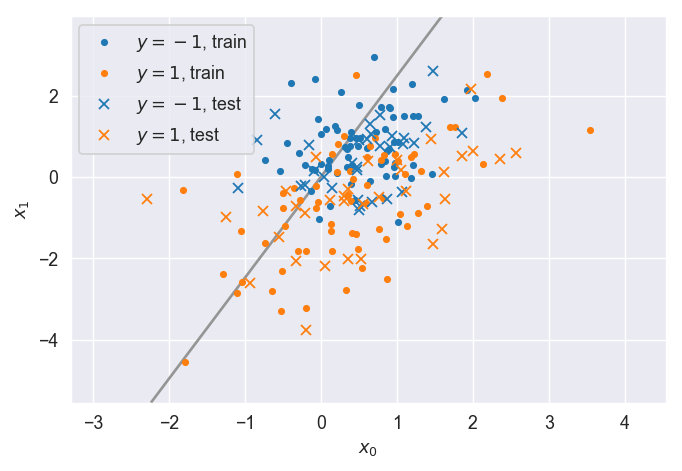

In [20]:
def plot_results(X_train, Y_train, X_test, Y_test, score_fn, threshold = 0):
    # Plot training set
    plt.plot(X_train[Y_train==-1,0], X_train[Y_train==-1,1], ".", label=r"$y=-1$, train")
    plt.plot(X_train[Y_train==1,0], X_train[Y_train==1,1], ".", label=r"$y=1$, train")
    plt.gca().set_prop_cycle(None) # reset colour cycle

    # Plot test set
    plt.plot(X_test[Y_test==-1,0], X_test[Y_test==-1,1], "x", label=r"$y=-1$, test")
    plt.plot(X_test[Y_test==1,0], X_test[Y_test==1,1], "x", label=r"$y=1$, test")

    # Compute axes limits
    border = 1
    x0_lower = X[:,0].min() - border
    x0_upper = X[:,0].max() + border
    x1_lower = X[:,1].min() - border
    x1_upper = X[:,1].max() + border

    # Generate grid over feature space
    resolution = 0.01
    x0, x1 = np.mgrid[x0_lower:x0_upper:resolution, x1_lower:x1_upper:resolution]
    grid = np.c_[x0.ravel(), x1.ravel()]
    s = score_fn(grid).reshape(x0.shape)

    # Plot decision boundary (where s(x) == 0)
    plt.contour(x0, x1, s, levels=[0], cmap="Greys", vmin=-0.2, vmax=0.2)

    plt.legend()
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()
    
plot_results(X_train, Y_train, X_test, Y_test, lambda X: weighted_sum(X, w, b))

**Question:** How well does the decision boundary separate the points in the two classes? How does it perform if you reduce the `class_sep` parameter in the `create_toy_dataset` function above?

To evaluate the perceptron quantitatively, we'll use the error rate (proportion of misclassified instances).
The error rate is a reasonable evaluation measure to use for this data since the classes are well balanced.

Complete the `evaluate` function below.

In [21]:
def evaluate(X, Y, w, b):
    """
    Returns the proportion of misclassified instances (error rate)
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    Y : numpy array, shape: (n_instances,)
        target class labels relative to X
    w : numpy array, shape: (n_features,)
        weights vector
    b : float
        bias term
    """
    return np.mean(predict(X,w,b) != Y) # fill in

print(evaluate(X_train, Y_train, w, b))

0.44776119402985076


The code block above computes the error rate on the training data, which is not a good idea in general. (Why?)

Compute the error rate on the test set instead.

In [22]:
print(evaluate(X_test, Y_test, w, b)) # fill in

0.4696969696969697


**Question:** How does this compare to the error on the training set? Is it what you expected?

Let's now examine how the train/test error rates vary as a function of the number of epochs. Note that careful tuning of the learning rate is needed to get sensible behaviour. Setting $\eta(t) = \frac{1}{1+t}$ where $t$ is the epoch number often works well, the technical term of this is _learning rate annealing_. 

Number of errors 52 / 134 iterations
Number of errors 48 / 134 iterations
Number of errors 48 / 134 iterations
Number of errors 51 / 134 iterations
Number of errors 51 / 134 iterations
Number of errors 50 / 134 iterations
Number of errors 48 / 134 iterations
Number of errors 52 / 134 iterations
Number of errors 52 / 134 iterations
Number of errors 52 / 134 iterations
Number of errors 52 / 134 iterations
Number of errors 50 / 134 iterations
Number of errors 50 / 134 iterations
Number of errors 50 / 134 iterations
Number of errors 56 / 134 iterations
Number of errors 52 / 134 iterations
Number of errors 48 / 134 iterations
Number of errors 44 / 134 iterations
Number of errors 50 / 134 iterations
Number of errors 51 / 134 iterations
Number of errors 50 / 134 iterations
Number of errors 50 / 134 iterations
Number of errors 50 / 134 iterations
Number of errors 46 / 134 iterations
Number of errors 48 / 134 iterations
Number of errors 52 / 134 iterations
Number of errors 50 / 134 iterations
N

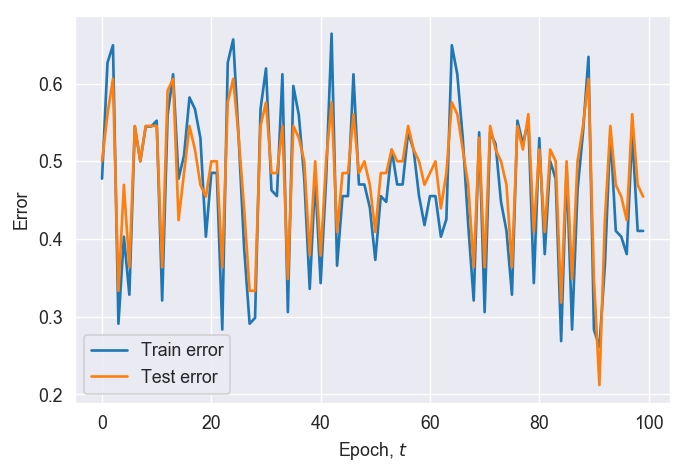

In [23]:
w_hat = np.zeros(X_train.shape[1]); b_hat = 0
n_epochs = 100

# Initialize arrays to store errors for each epoch
train_error = np.empty(n_epochs)
heldout_error = np.empty(n_epochs)

for t in range(n_epochs):
    # here we use a learning rate, which decays with each epoch
    eta = 1./(1+t)
    w_hat, b_hat = train(X_train, Y_train, w_hat, b_hat, n_epochs=1, eta=eta)    
    train_error[t] = evaluate(X_train, Y_train, w_hat, b_hat)
    heldout_error[t] = evaluate(X_test, Y_test, w_hat, b_hat)

plt.plot(train_error, label = 'Train error')
plt.plot(heldout_error, label = 'Test error')
plt.legend()
plt.xlabel('Epoch, $t$')
plt.ylabel('Error')
plt.show()

**Question:** Has the model changed significantly after training for more epochs (i.e. more than 5)? You can plot the new decision boundary by running the code block below.

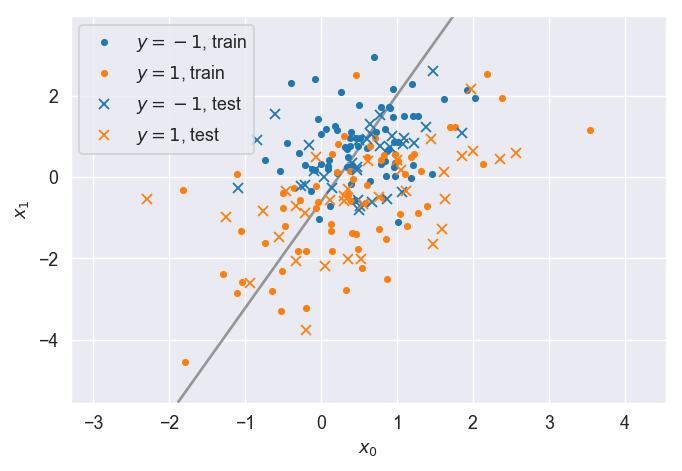

In [24]:
plot_results(X_train, Y_train, X_test, Y_test, lambda X: weighted_sum(X, w_hat, b_hat))

### 5. Repeat with class overlap
By now you've probably concluded that the perceptron performs well on this data (`class_sep=2`), which is to be expected as it's roughly linearly separable. 
However, we know (from lectures) that the perceptron can fail on non-linearly separable data.
To test this scenario, re-generate the synthetic data set with `class_sep=0.5` and repeat Sections 2–4.

**Question:** What do you find? Pay particular attention to plot of the error vs. training epochs. Do you notice anything unusual?

**Answer:** As mentioned in the previous answer, the model becomes highly unstable—the optimisation algorithm doesn't really converge to a good "approximate" solution. As a result, the train/test errors fluctuate wildly.

### 6. Comparison with logistic regression
We've seen that the perceptron is not robust to binary classification problems with overlapping classes. 
But how does logistic regression fare in this case?

Run the code block below to fit a logistic regression model using `sklearn`. 
You may wish to switch off regularisation (alter the `C` parameter) for a fairer comparison with the perceptron.

In [25]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, Y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Let's plot the decision boundary.

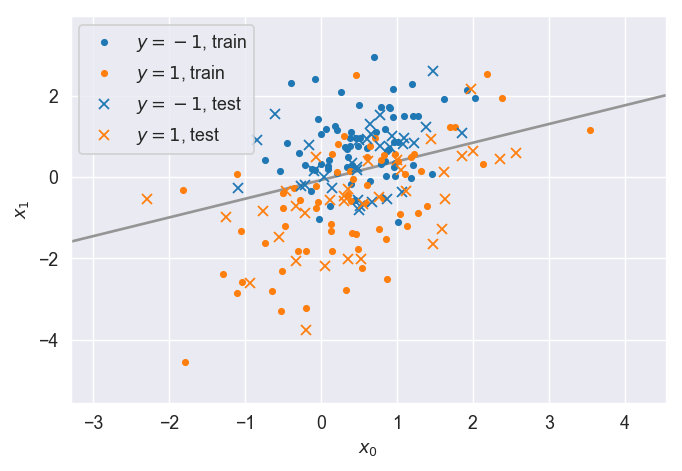

In [26]:
plot_results(X_train, Y_train, X_test, Y_test, lambda X: clf.decision_function(X))

**Question:** How does the logistic regression classifier compare to the perceptron? If we used the same weights for both the Perceptron and a logistic regression classifier (in the original feature space), which would perform better? *Hint: Consider the decision boundary for each.*

**Question:** Compute the error rate for the logistic regression classifier and compare it to the error rate for the perceptron (for `class_sep=0.5`). *Hint: you may wish to use `clf.score(...)`*

In [27]:
1.0 - clf.score(X_test, Y_test) # fill in

0.2272727272727273

## Exercise 1
In the following exercise we will work through a proof of the perceptron convergence algorithm. We make the following assumptions:
* The feature vectors lie in a sphere of radius $R$: $\vert \mathbf{x}_n \vert \leq R \; \forall \;n$, i.e. their maximum length is $R$.
* The data is linearly separable with margin $2\gamma > 0$. That is, there exists a unit normal vector to the hyperlane $\mathbf{w}^*$ such that $y_i \mathbf{w}^* \cdot \mathbf{x}_n \geq \gamma$ and $\vert \mathbf{w}^* \vert = 1$. Note that $\mathbf{w}^* \cdot \mathbf{x}_n $ can be thought of as the shortest (Euclidean) distance from the hyperplane to a given training instance $\mathbf{x}_n$, as you will see when we study SVMs.

Given a sequence $\mathbf{x}_1, \ldots, \mathbf{x}_T$ of $T$ instances, we want to find a bound on the total number of updates the Perceptron algorithm will make in this scenario. Let us only consider the subset of iterations $\mathcal{K}$ of the $T$ rounds where the Perceptron makes an error, and we have to make an update. So we are interested in finding the number of updates $\vert \mathcal{K} \vert$. Note we have a trivial bound of $\vert \mathcal{K} \vert = T$ - where the algorithm makes an error at every iteration. We would like to obtain a more 'efficient' bound than this.

1. Assume there is an error at iteration $k \in \mathcal{K}$ and we initialize $\mathbf{w}_0 = \mathbf{0}$. Prove that 

   $$ \mathbf{w}^* \cdot \mathbf{w}_{k+1} \geq (k+1) \gamma $$
   
2. Use the fact that the instances $\mathbf{x}_k$ are bounded to show that

   $$ || \mathbf{w}_k ||^2 \leq k R^2 $$
   
3. Use the definition of the dot product, $\mathbf{u} \cdot \mathbf{v} = \vert \mathbf{u} \vert \vert \mathbf{v} \vert \cos \theta $, where $\theta$ is the angle between $\mathbf{u}$ and $\mathbf{v}$, to prove that

   $$ \mathbf{w}^* \cdot \mathbf{w}_k \leq \vert \mathbf{w}^*\vert \vert \mathbf{w}_k \vert $$
   
4. Use the above inequalities to prove that the number of updates is bounded:
   $$ k \leq \frac{R^2}{\gamma^2} $$
   
In other words, no misclassified sample exists after at most $\frac{R^2}{\gamma^2}$ steps! 

**Discussion:** Is this what you expect? Does this bound make sense intuitively?

We can also obtain bounds on the number of updates when training on the sequence $\mathbf{x}_1, \ldots, \mathbf{x}_T$ for the more general case of non-linearly separable data in terms of the hinge loss of our classifier! Another time, perhaps.